### Imports

In [1]:
import jax.numpy as jnp
from jax.experimental.optimizers import adam, nesterov, sm3, rmsprop
from jax import jit

from jax.config import config

from bfs_src import ekf, ieks, meks, MVNormalParameters, eks
from bfs_src.models.bearings import get_data, make_parameters, plot_bearings

config.update("jax_enable_x64", True)

### Input parameters

In [2]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
dt = 0.01  # discretization time step
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 1000  # number of observations

### Get parameters

In [3]:
Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

### Get data

In [4]:
ts, true_states, observations = get_data(x0, dt, r, T, s1, s2, random_state=42)

### We can now run the filter and smoother

Initial state guess

In [5]:
m = jnp.array([-1., -1., 0., 0., 0.])
P = jnp.eye(5)

initial_guess = MVNormalParameters(m, P)

Run the filter

In [6]:
initial_states = MVNormalParameters(jnp.zeros((T, 5)), jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T, axis=0))

In [7]:
filtered, ll = ekf(initial_guess, 
                   observations, 
                   transition_function, 
                   Q, 
                   observation_function, 
                   R, 
                   initial_states.mean)

In [8]:
smoothed = eks(transition_function, Q, filtered)

### The iterated one

In [9]:
iterated_smoothed_trajectories = ieks(initial_guess, 
                                      observations, 
                                      transition_function, 
                                      Q, 
                                      observation_function, 
                                      R, 
                                      initial_states, 
                                      n_iter=100)

### And the optimized one

In [12]:
def regularization_function(states):
    return jnp.sum(jnp.linalg.norm(states[1:, :-1] - states[:-1, :-1], 1, 1))

optimized_smoothed_trajectories, linearization_trajectory = meks(initial_guess, 
                                                                 observations, 
                                                                 transition_function, 
                                                                 Q, 
                                                                 observation_function, 
                                                                 R, 
                                                                 iterated_smoothed_trajectories, 
                                                                 regularization_function=regularization_function,
                                                                 reg=5., 
                                                                 method=rmsprop,
                                                                 step_size=1e-3,
                                                                 num_steps=1000)

Current loss: 1552.17, Max grad: 11.593094706282056: 100%|██████████| 1000/1000 [00:30<00:00, 33.25it/s]


Final log-lik:  -1446.8797675743713


### For comparison we can run the sequential iterated smoother too

### Plot the result

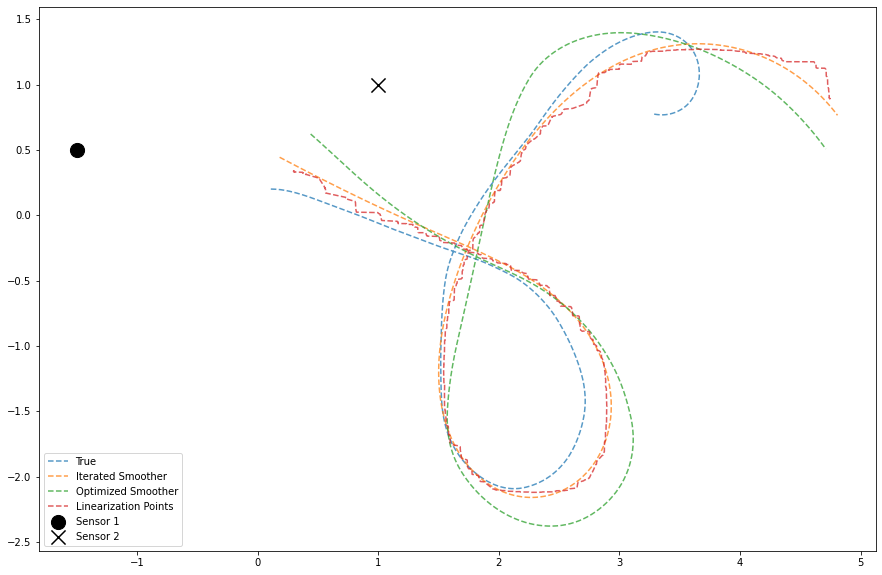

In [13]:
plot_bearings([true_states, iterated_smoothed_trajectories.mean, optimized_smoothed_trajectories.mean, linearization_trajectory], 
              ["True", "Iterated Smoother", "Optimized Smoother", "Linearization Points"], 
              s1, s2, figsize=(15, 10), quiver=False)

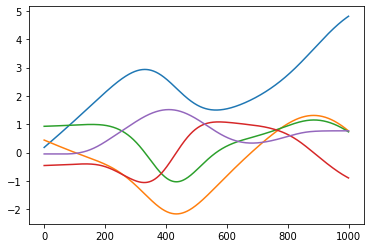

In [18]:
import matplotlib.pyplot as plt
plt.plot(iterated_smoothed_trajectories.mean)

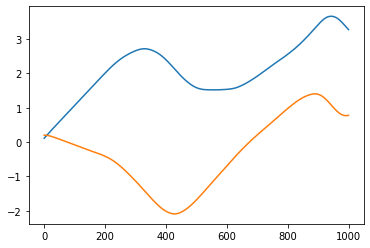

In [19]:
plt.plot(true_states[:, :2])

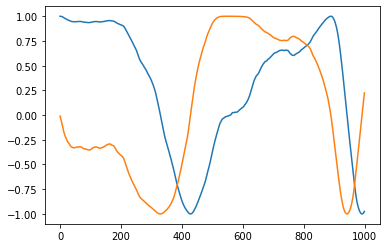

In [20]:
plt.plot(true_states[:, 2:4])

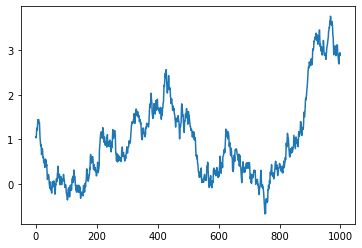

In [21]:
plt.plot(true_states[:, -1])